## Ensemble Learning - Combining Different ML algorithms



This notebook will look at the most popular and widely used techniques for ensemble learning.


Data 

Data Source available at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing# 

This data is related with a bank marketing campaign (phone calls).

The bank's business goal is to attract new clients to open a Certificate of Deposit i.e., to predict if a prospect will open a CD.



- We've cleaned the data and performed EDA.


Loading the data:


In [54]:
#imports

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings('ignore')


df= pd.read_csv('C:/Users/uknow/Desktop/bank_final2.csv')

df.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,campaign,pdays,previous,poutcome,['y']_yes
41183,1,5,1,5,0,2,0,0,7,0,...,-1.1,94.767,-50.8,1.028,4963.6,1,999,0,1,1
41184,1,1,1,5,0,0,0,0,7,0,...,-1.1,94.767,-50.8,1.028,4963.6,1,999,0,1,0
41185,1,5,1,6,0,2,0,0,7,0,...,-1.1,94.767,-50.8,1.028,4963.6,2,999,0,1,0
41186,1,9,1,5,0,0,0,0,7,0,...,-1.1,94.767,-50.8,1.028,4963.6,1,999,0,1,1
41187,1,5,1,5,0,2,0,0,7,0,...,-1.1,94.767,-50.8,1.028,4963.6,3,999,1,2,0


In [6]:
#There are 41188 observations and 21 columns
df.shape

(41188, 21)

In [5]:
df.dtypes

age                 int64
job                 int64
marital             int64
education           int64
default             int64
housing             int64
loan                int64
contact             int64
month               int64
day_of_week         int64
duration            int64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
campaign            int64
pdays               int64
previous            int64
poutcome            int64
['y']_yes           int64
dtype: object

In [11]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'campaign', 'pdays', 'previous', 'poutcome', '['y']_yes'],
      dtype='object')

In [14]:
df.rename(columns = {"['y']_yes":'y'}, inplace = True) 

In [15]:
X= pd.read_csv('C:/Users/uknow/Desktop/bank_final.csv')

## train_test_split: 80/20

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df.y, test_size=0.2, random_state=2019)

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32950, 20) (32950,)
(8238, 20) (8238,)


### Majority Vote Classifier

Using the training dataset we  will train 3 different classifiers: 
logistic regression, decision tree and KNN. 

First we look at their individual performances via a k=10 fold cross-validation on the training dataset. 

Then we combine them into an ensemble classifier


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

Logistic Regression and KNN algorithms require feature scaling
for optimal performance

In [24]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

For consistency, we will train the logistic regression and KNN as part of a pipeline and build 3 models:

In [25]:
from sklearn.pipeline import Pipeline

In [33]:
lreg = LogisticRegression(penalty='l2', C=0.001,random_state=0)
model_tree = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
knn = KNeighborsClassifier(n_neighbors=1, p=2,metric='minkowski')
model_reg = Pipeline([['sc', StandardScaler()], ['model', lreg]])
model_knn = Pipeline([['sc', StandardScaler()], ['model', knn]])

model_names = ['Logistic Regression', 'Decision Tree', 'KNN']



## k = 10 fold cross-validation

shows that predictive performance of each individual model is almost the same:

In [34]:
for model, name in zip([model_reg, model_tree, model_knn], model_names):
    scores = cross_val_score(estimator = model, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f)  - %s "% (scores.mean(), scores.std(), name))
    

ROC AUC: 0.92 (+/- 0.01)  - Logistic Regression 
ROC AUC: 0.70 (+/- 0.01)  - Decision Tree 
ROC AUC: 0.69 (+/- 0.01)  - KNN 


## Combining the individual classifiers into an ensemble classifier: Majority Voting


In [45]:
from sklearn.ensemble import VotingClassifier

# default=hard - predicts class labels for majority rule voting
ens =  VotingClassifier(estimators=[('lr', model_reg), ('tree', model_tree), ('knn', model_knn)], voting='hard')
                          

In [48]:
ens.fit_transform(X_train, y_train)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 1]], dtype=int64)

In [90]:
for model, name in zip([model_reg, model_tree, model_knn, ens], model_names):
    model.fit(X_train, y_train)
    model.predict(X_test)
    print("R2: %0.2f (train)  %0.2f (test) - %s "% (model.score(X_train, y_train), model.score(X_test, y_test), name))

R2: 0.91 (train)  0.91 (test) - Logistic Regression 
R2: 0.89 (train)  0.88 (test) - Decision Tree 
R2: 1.00 (train)  0.88 (test) - KNN 
R2: 0.92 (train)  0.90 (test) - Majority Voting 


### Accuracy:

**Accuracy score** is the proportion of correct classifications


"The advantage of using a **cross-validation estimator** over the canonical estimator class along with grid search is that they can take advantage of warm-starting by reusing precomputed results in the previous steps of the cross-validation process. This generally leads to speed improvements." (scikit-learn.org)

Based on the traditional academic point system:

.90-1 = excellent (A)

.80-.90 = good (B)

.70-.80 = fair (C)

.60-.70 = poor (D)

.50-.60 = fail (F)


The performance of the combined model using Majority Voting is excellent, a slight improvement over the individual KNN and Decision Tree classifiers in the 10-fold cross-validation evaluation

In [82]:
model_names += ['Majority Voting']

for model, name in zip([model_reg, model_tree, model_knn, ens], model_names):
    scores = cross_val_score(estimator = model, X=X_test, y=y_test, cv=10, scoring='accuracy')
   
    print("Accuracy: %0.2f - %s "% (scores.mean(), name))
    

Accuracy: 0.90 - Logistic Regression 
Accuracy: 0.88 - Decision Tree 
Accuracy: 0.88 - KNN 
Accuracy: 0.90 - Majority Voting 


## Bagging is another ensemble of classifiers 

uses bootstrap samples

Here we use an unpruned decision tree as the base classifier. Then create an ensemble of n_estimators=500 decision trees fitted on different bootstrap samples of the training dataset:


In [104]:
from sklearn.ensemble import BaggingClassifier

model_tree2 = DecisionTreeClassifier(max_depth=None, criterion='entropy')

bag = BaggingClassifier(base_estimator=model_tree2, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1,random_state=1)

#### Accuracy

- Compute accuracy score of the prediction on the training and test dataset

- Compare the performance of the bagging classifier to the performance of a single unpruned decision tree:

In [116]:
bag = bag.fit(X_train, y_train)

y_test_pred = bag.predict(X_test)

#Accuracy:

bag_score = accuracy_score(y_test, y_test_pred).mean()
print(bag_score)

0.9047098810390871


In [117]:
tree = model_tree2.fit(X_train, y_train)
y_test_pred = tree.predict(X_test)

#Accuracy:
tree_score = accuracy_score(y_test, y_test_pred).mean()
print(tree_score)

0.8868657441126487


In [118]:
score = (cross_val_score(model_tree2, X_train, y_train, cv=10, n_jobs=1, scoring = 'accuracy').mean())
print(score)

0.8871625586419805


##  Boosting is another ensemble learning technique 

In contrast to bagging, boosting algorithms use random subsets of training samples drawn from the training dataset without replacement. 


In boosting, the ensemble consists of very simple base classifiers (weak learners). A typical example is a decision tree.

"Boosting focuses on training samples that are hard ie, to let the weak learners subsequently learn from misclassified training samples to improve the performance of the ensemble."


### Gradient Boosting

" Gradient Boosting builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function..."

In [98]:
from sklearn.ensemble import GradientBoostingClassifier
model_gb = GradientBoostingClassifier()
model_gb.fit(X_train, y_train)
gbpred = gb.predict(X_test)


In [99]:
#Accuracy:

score = (cross_val_score(model_gb, X_train, y_train, cv=10, n_jobs=1, scoring = 'accuracy').mean())
print(score)

0.9150530262933009


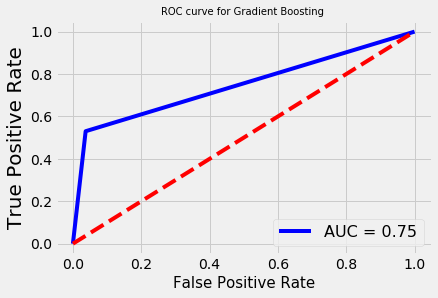

In [100]:
fprgbk, tprgbk, thresholdgbk = metrics.roc_curve(y_test, gbpred)

roc_aucgbk = metrics.auc(fprgbk, tprgbk)

plt.plot(fprgbk, tprgbk, 'b', label = 'AUC = %0.2f' % roc_aucgbk)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve for Gradient Boosting ',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 16})

plt.show()

In [120]:
print(' Performance Metrics Reports\n',classification_report(y_test, gbpred))

 Performance Metrics Reports
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      7267
           1       0.66      0.53      0.59       971

   micro avg       0.91      0.91      0.91      8238
   macro avg       0.80      0.75      0.77      8238
weighted avg       0.91      0.91      0.91      8238



## Random Forest is another ensemble model

Classifies the data set by taking a majority vote of each leaf value

In [121]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators = 200)#criterion = entopy,gini
model_rf.fit(X_train, y_train)
rfpred = model_rf.predict(X_test)


In [128]:
#Accuracy 
print(round(accuracy_score(y_test, rfpred),2)*100)

91.0


In [126]:
print(' Performance Metrics Reports\n',classification_report(y_test, rfpred))

 Performance Metrics Reports
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      7267
           1       0.63      0.51      0.57       971

   micro avg       0.91      0.91      0.91      8238
   macro avg       0.78      0.74      0.76      8238
weighted avg       0.90      0.91      0.90      8238



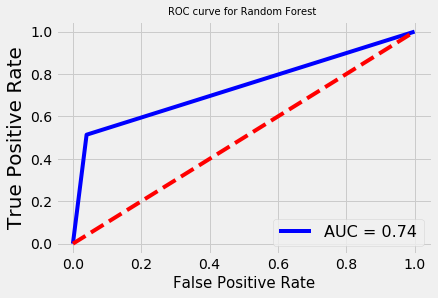

In [130]:
fprgbk, tprgbk, thresholdgbk = metrics.roc_curve(y_test, rfpred)

roc_aucgbk = metrics.auc(fprgbk, tprgbk)

plt.plot(fprgbk, tprgbk, 'b', label = 'AUC = %0.2f' % roc_aucgbk)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve for Random Forest ',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 16})

plt.show()



## Ensemble learning algorithms combine different ML to cancel out their individual weakness

Our winner ensemble model is Gradient Boosting.

Ensemble learning are stable and well-performing and therefore they are most popular in machine learning competitions and industrial applications.
